# Machine Learning for Social Media-Based Depression Analysis

## Business Understanding

Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities


## Data Understanding

Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

title: The title of the Reddit post.

body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

num_comments: The number of comments on each post, which could provide insights into community engagement.

label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.


In [2]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
import string

from scipy.sparse import csr_matrix

In [3]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  # 
data = pd.read_csv(r"C:\Users\admin\Documents\Flatiron\Phase-5\final_project\Data\reduced_reddit.csv", index_col=False)
data.head(10)  # Display the first few rows of the dataframe


,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0
5,teenagers,"Phew , close one",NaN,11.0,1.587389e+09,NaN,0.0
6,teenagers,Listen to my favorite song part 2 🤩🤩🤩,https://youtu.be/MtN1YnoL46Q,9.0,1.610744e+09,11.0,0.0
7,teenagers,Hard core cuddling,#moans,41.0,1.625997e+09,19.0,0.0
8,teenagers,Don't communicate with women.,I watched my friend go to high five a girl and...,7.0,1.557873e+09,11.0,0.0
9,teenagers,Do you guys just ever want to be left alone?,"Just, after a bunch of socialising I want to c...",5.0,1.511478e+09,10.0,0.0


In [4]:
#check the dataset information 
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [5]:
#check on the description of numerical datatypes
data.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


## Data Cleaning
### Handling missing values in body

In [6]:
#check to see if there are null values in percentage form
data.isnull().sum() / len(data) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

The dataset has some columns that have null values, namely body and num_comments. The latter has 18% of the rows with missing values while the former has averagely 5% of missing values which we can drop these missing rows as it makes a small percentage of the data. 
For the body column, I will impute the missing values by filling with the text "no content".  

In [7]:
# Dropping all the nan values
data = data.dropna(subset=["body", 'num_comments']).reset_index(drop=True)

#check to see if there are null values remaining
data.isnull().sum() / len(data) * 100

subreddit       0.0
title           0.0
body            0.0
upvotes         0.0
created_utc     0.0
num_comments    0.0
label           0.0
dtype: float64

In [8]:
# Checking for null values and confirming data shape after cleaning to ensure nomissing values
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77051 entries, 0 to 77050
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     77051 non-null  object 
 1   title         77051 non-null  object 
 2   body          77051 non-null  object 
 3   upvotes       77051 non-null  float64
 4   created_utc   77051 non-null  float64
 5   num_comments  77051 non-null  float64
 6   label         77051 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.1+ MB


(None, (77051, 7))

In [9]:
# Convert 'created_utc' column from UTC epoch time to datetime
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')

# To see the updated DataFrame
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77051 entries, 0 to 77050
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   subreddit     77051 non-null  object        
 1   title         77051 non-null  object        
 2   body          77051 non-null  object        
 3   upvotes       77051 non-null  float64       
 4   created_utc   77051 non-null  datetime64[ns]
 5   num_comments  77051 non-null  float64       
 6   label         77051 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 4.1+ MB


(None, (77051, 7))

## Exploratory Data Analysis

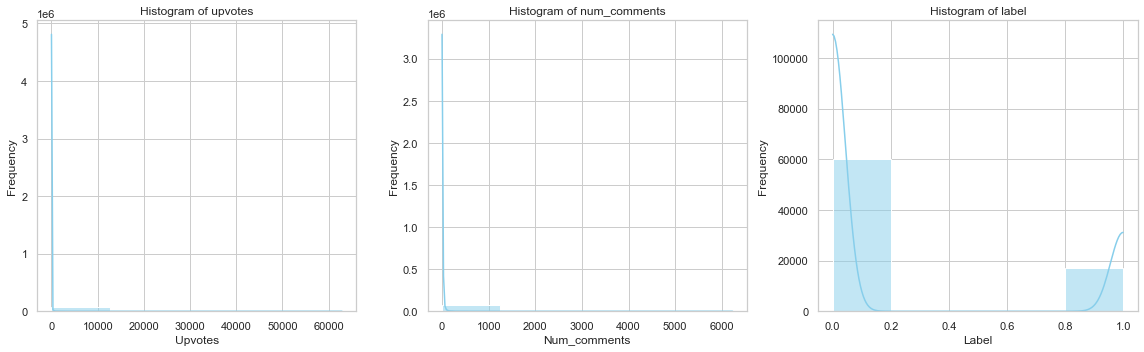

In [10]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set_theme(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

teenagers       59164
depression      10398
SuicideWatch     6681
happy             540
DeepThoughts      268
Name: subreddit, dtype: int64
0.0    59972
1.0    17079
Name: label, dtype: int64


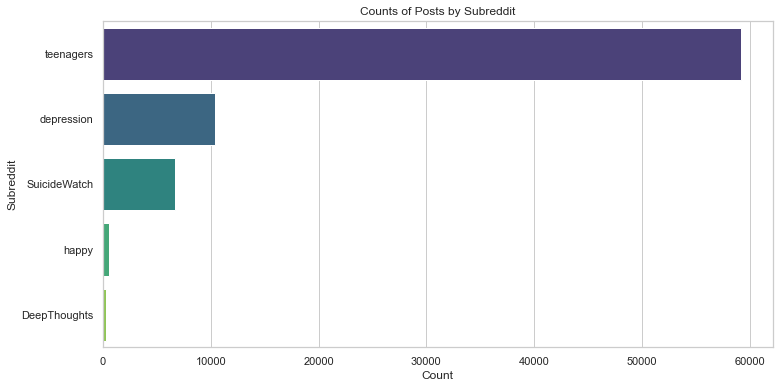

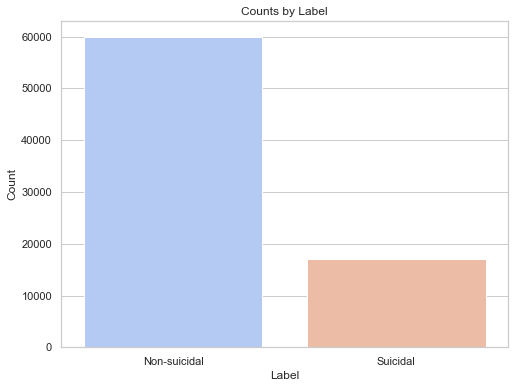

In [11]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(data['subreddit'].value_counts())

# Frequency of 'label' column
print(data['label'].value_counts())

# Set style
sns.set_theme(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='subreddit', order=data['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])
plt.show()


## Bivariate Analysis

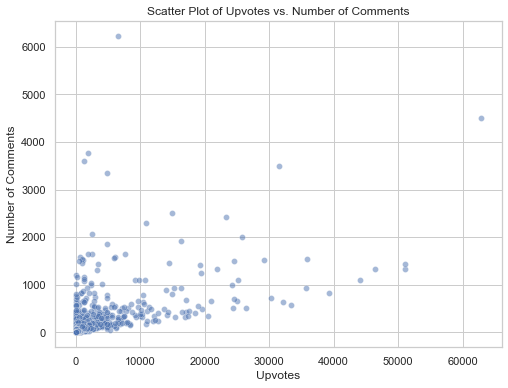

In [12]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', data=data, alpha=0.5)
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()



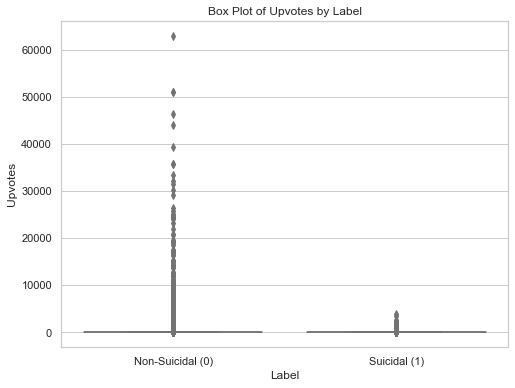

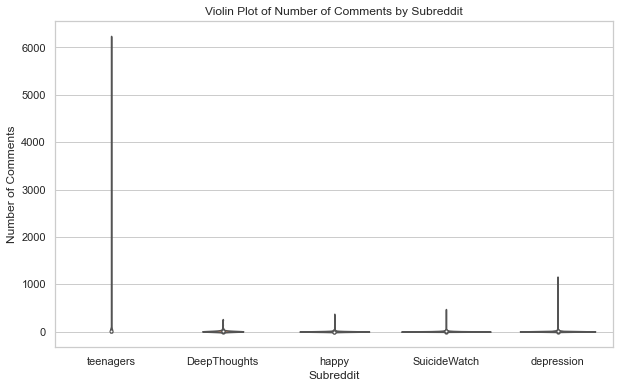

In [13]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', data=data, palette='pastel')
plt.title("Box Plot of Upvotes by Label")
plt.xlabel("Label")
plt.ylabel("Upvotes")
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='num_comments', data=data, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.show()

Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    268      0
SuicideWatch      0   6681
depression        0  10398
happy           540      0
teenagers     59164      0


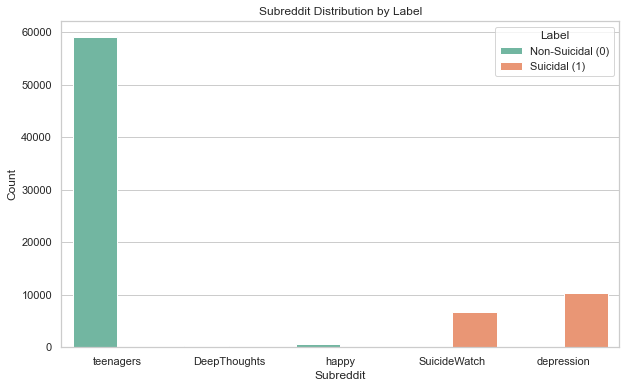

In [14]:
# Crosstab between 'subreddit' and 'label'
cross_tab = pd.crosstab(data['subreddit'], data['label'])
print("Crosstab of Subreddit by Label:")
print(cross_tab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="subreddit", hue="label", palette="Set2")
plt.title("Subreddit Distribution by Label")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

## Multivariate Analysis

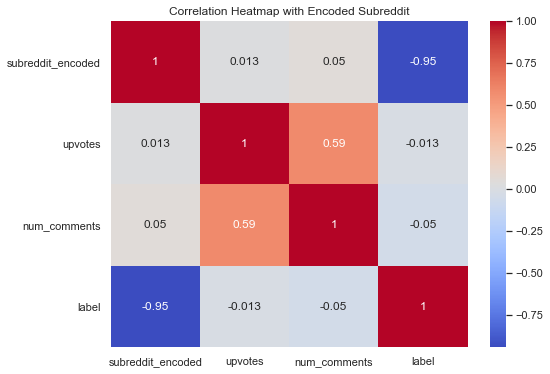

In [15]:
# Convert the 'subreddit' column to numeric using label encoding
data['subreddit_encoded'] = LabelEncoder().fit_transform(data['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

# Sentiment Analysis

In [16]:
# Initializing stopwords, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#define a class TextPreprocessor that conforms to scikit-learn’s transformer API
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required for this transformer

    def transform(self, X, y=None):
        return X.apply(self._preprocess_text)
    def _preprocess_text(self, text):
        if pd.isnull(text):
            return ''  # Return empty string for missing values
        text = text.lower()  # Lowercase
        text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
        return ' '.join(tokens)  # Join tokens back into string


# Instantiate TextPreprocessor
text_preprocessor = TextPreprocessor()

# Apply the text preprocessor to 'title' and 'body' columns
data['processed_title'] = text_preprocessor.transform(data['title'])
data['processed_body'] = text_preprocessor.transform(data['body'])

# Display the processed data
data[['processed_title', 'processed_body']]

,processed_title,processed_body
0,lmaooo get guy talk talk god💖💖,yeahhh maybe babe
1,guy found hurtful child movie kid female chara...,like funny deserve better male character kick ...
2,listen favorite song part 2 🤩🤩🤩,httpsyoutubemtn1ynol46q
3,hard core cuddling,moan
4,dont communicate woman,watched friend go high five girl looked kinda ...
...,...,...
77046,anyone ever problem gang,dont care grammer isnt good dont even bring se...
77047,moment away killing even bothering make throw ...,dont want talk problem dont want talk problem ...
77048,ive grown used like year,im suicidal moment fact feel great right time ...
77049,speech lord ring really inspires go,like great story mr frodo one really mattered ...


In [17]:
# TF-IDF give higher weights to words that are less common across documents.

# Apply TF-IDF to the title and body columns separately
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # limiting to top 10,000 features_to manage vocabulary size


# Using the processed title and body columns 
tfidf_title = tfidf_vectorizer.fit_transform(data['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(data['processed_body'])

# keeping these as sparse matrices which we can also concatenate directly if needed for model input
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body) # in sparse format, to save memory

### Token analysis

In [18]:
#Examining the top words by TF-IDF Scores

# Display the top terms with the highest TF-IDF scores
tfidf_sum = combined_features.sum(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_sum.A1})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Displaying the top 50 terms with the highest TF-IDF scores
tfidf_df.head(50)

,word,tfidf_score
4561,im,2709.434082
5271,like,2588.668313
2834,dont,1734.116298
3500,feel,1637.737548
9639,want,1637.021082
5084,know,1623.855277
4497,hurting,1577.283690
3927,get,1548.242333
4132,guy,1392.279880
3778,friend,1342.874309


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Spliting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['body'], data['label'], test_size=0.2, random_state=42)

# Creating a pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred, target_names=['Non-Depression', 'Depression'])
print(report)


                precision    recall  f1-score   support

Non-Depression       0.93      0.97      0.95     12040
    Depression       0.87      0.73      0.79      3371

      accuracy                           0.92     15411
     macro avg       0.90      0.85      0.87     15411
  weighted avg       0.91      0.92      0.91     15411



### Performing hyperparameter tunning
- This will improve performance of our model

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'clf__C': [0.1, 1, 10],  # Regularization strength
    'clf__penalty': ['l2']  # 'liblinear' solver supports only 'l2'
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 3 folds for each of 54 candidates, totalling 162 fits


({'clf__C': 10,
  'clf__penalty': 'l2',
  'tfidf__max_df': 0.9,
  'tfidf__min_df': 1,
  'tfidf__ngram_range': (1, 2)},
 0.9169115301282754)

### The model has an approximate 92.23% accuracy on the evaluation data in the best combination of settings from Logistic regression classifier and TF-IDF Vectorizer.
- This indicates strong performance in classifying the text thus the hyperparameters seem to be well suited for the problem.

## BERT Model

In [21]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# **Before creating the dataset objects, ensure labels are integers 0 and 1:**
y_train = y_train.astype(int)  # Convert y_train to integers
y_test = y_test.astype(int)  # Convert y_test to integers

# Initializing BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the dataset
train_encod = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encod = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Converting labels to torch tensors
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Creating torch dataset classes
class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Creating dataset objects
train_dataset = DepressionDataset(train_encod, train_labels)
test_dataset = DepressionDataset(test_encod, test_labels)

# Loading pre-trained BERT model for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    # **Add the following line to enable device-side assertions for debugging:**
    report_to='none' # This line disables reporting to wandb and other loggers
)

# Defining metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Initializing Trainer
traine = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer), # remove processing_class = tokenizer
    compute_metrics=compute_metrics
)

# Training the model
traine.train()

# Evaluating the model
eval_result = traine.evaluate()
print(eval_result)

c:\Users\admin\anaconda3\envs\learn-env\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`